# Homework 9

In [38]:
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
from matplotlib import pyplot as plt
from filterpy.kalman import KalmanFilter

PI = np.pi

Group Members: Adrienne Christensen, DT Litster, Melanie Neller, Nathan Schill, Dallin Seyfried

In this homework project, you will create a model of the value of single family homes built in 1985 or later in an area of your choice (outside of Utah valley).  You will use Kalman filtering to update your forecast with data.

# Problem 1

Choose a real estate market outside of Utah County. Create a model that
depends on time to predict the value of single family homes built 1985 or
later. You may include other input to your model like home size, lot size,
etc, but you also need to include time as an input. Explain your model in
detail.

### Fit model to data

Aggregate housing data by month

In [39]:
filepath = "nyc-property-sales-cleaned.csv"

df = pd.read_csv(filepath, parse_dates=["SALE DATE"])
df["YEAR BUILT"] = pd.to_datetime(df["YEAR BUILT"], format="%Y")

df = df.drop(["NEIGHBORHOOD", "ADDRESS"], axis=1)

In [40]:
df["price_per_land_sq_ft"] = df["SALE PRICE"] / df["LAND SQUARE FEET"]
df["price_per_gross_sq_ft"] = df["SALE PRICE"] / df["GROSS SQUARE FEET"]

In [41]:
grouped = df.groupby(pd.Grouper(key="SALE DATE", freq="ME"))
means = grouped.mean()

land, gross = means["price_per_land_sq_ft"], means["price_per_gross_sq_ft"]
datasets = {"land": land, "gross": gross}

means

,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,price_per_land_sq_ft,price_per_gross_sq_ft
SALE DATE,,,,,,
2018-01-31,2811.871951,1695.426829,1998-02-12 05:07:19.024390272,685214.091463,326.876688,374.715699
2018-02-28,2797.036232,1732.550725,2000-10-26 10:15:39.130434816,650597.760870,306.656582,373.854224
2018-03-31,2926.098039,1759.764706,2000-02-18 03:08:14.117647104,602562.869281,257.935402,338.368969
2018-04-30,2687.484472,1697.204969,1997-12-25 02:14:09.689441024,594740.906832,296.220016,342.973897
2018-05-31,2718.956790,1675.512346,1997-10-13 23:42:13.333333376,585146.814815,286.650988,339.981770
...,...,...,...,...,...,...
2023-07-31,2606.571429,1841.647619,1999-03-08 05:29:08.571428608,881733.647619,440.204853,451.299919
2023-08-31,3038.734375,1734.539062,1997-11-04 19:18:45.000000000,800452.906250,345.625814,453.075644
2023-09-30,2950.067961,1885.718447,1995-12-21 17:14:33.786407808,887932.310680,417.067883,446.056076


In [42]:
def plot(name):
    data = datasets[name]

    tls = np.arange(len(data))

    fig, ax = plt.subplots(1, 1)

    ax.plot(tls, data, color="C0", label="true")

    ax.set_xlabel("month")
    ax.set_ylabel(rf" \$ / ft$^2$ ({name})")

    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(tls[::12])
    ax2.set_xticklabels((tls[::12] / 12).astype(int))
    ax2.set_xlabel("year")

    ax.set_title(rf" \$ / ft$^2$ ({name})")
    fig.tight_layout()

    return fig, ax


def model(t, z, a1, a2, b1, b2, b3, b4):
    return (
        z
        + a1 * np.exp(a2 * t / 12)
        + b1 * np.sin(b2 * 2 * PI / 12 * t + b3) * np.exp(b4 * t / 12)
    )

### Gross

Below, `monthly_ratios` contains the average monthly percent change in the price per square foot (gross) over the ~6 years of data

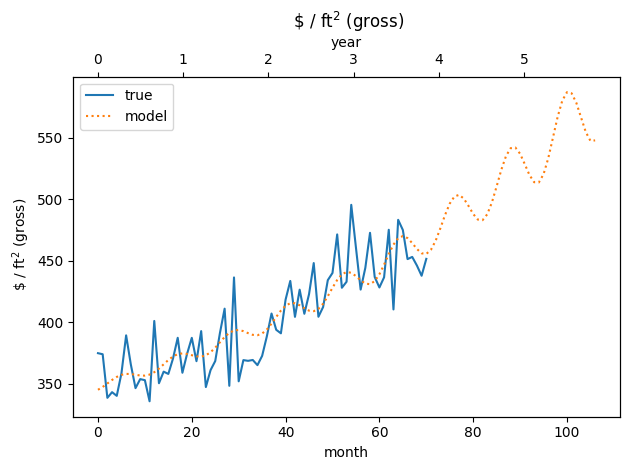

In [43]:
name = "gross"

data = datasets[name]
tls = np.arange(len(data))

params, pcov = curve_fit(model, tls, data)

fig, ax = plot(name)
years = 3
tls = np.arange(len(data) + years * 12)
ax.plot(tls, model(tls, *params), label="model", color="C1", ls=":")

ax.legend()
fig.tight_layout()
plt.show()

In [44]:
np.round(params, 2), np.round(pcov, 2)

f = lambda t: model(t, *params)
tls = np.arange(len(data) + 1)

ratios = f(tls + 1) / f(tls)
reshaped = ratios.reshape(-1, 12)
monthly_ratios = reshaped.mean(axis=0)

reshaped[:, 0], monthly_ratios

(array([1.00668749, 1.00813423, 1.00990657, 1.01206762, 1.01468779,
        1.01784396]),
 array([1.01155461, 1.01312199, 1.01224891, 1.00916218, 1.0046709 ,
        0.99994033, 0.99622244, 0.99457716, 0.99559717, 0.99917971,
        1.00444832, 1.00993749]))

### Land

Below, `monthly_ratios` contains the average monthly percent change in the price per square foot (land) over the ~6 years of data

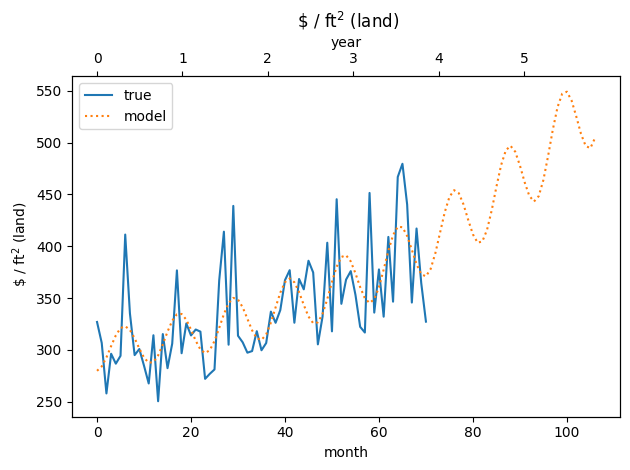

In [45]:
name = "land"

data = datasets[name]
tls = np.arange(len(data))

params, pcov = curve_fit(model, tls, data)

fig, ax = plot(name)
years = 3
tls = np.arange(len(data) + years * 12)
ax.plot(tls, model(tls, *params), label="model", color="C1", ls=":")

ax.legend()
fig.tight_layout()
plt.show()

In [46]:
np.round(params, 2), np.round(pcov, 2)

f = lambda t: model(t, *params)
tls = np.arange(len(data) + 1)

ratios = f(tls + 1) / f(tls)
reshaped = ratios.reshape(-1, 12)
monthly_ratios = reshaped.mean(axis=0)

reshaped[:, 0], monthly_ratios

(array([1.01516355, 1.02220729, 1.02933196, 1.03613134, 1.04217074,
        1.0470396 ]),
 array([1.03200741, 1.04138527, 1.03982343, 1.02866477, 1.01152415,
        0.99283269, 0.9770066 , 0.9680219 , 0.96883073, 0.98025495,
        0.99974694, 1.02134888]))

# Explanation

Our model computes the price per square foot of land area per month and then averages it over the duration of time of the data, so about the last 6 years. This gives an average of the percent change of the price per square foot per month based on the last 6 years of data in our dataset. This allows us to predict the price of a single family home depending on the time and the square footage. We decided to use price per gross square foot (of the house) rather than the price per land square foot. 

# Problem 2

Obtain freely available, but noisy data regarding the value of single family
homes in the market you chose. Talk to me please if you need ideas on
how to obtain that.

We downloaded and cleaned a dataset from Kaggle.com that had been compiled from
data available from the city of New York. We removed sales less than $100,000
removed all columns other than sale price, sale date, year built, neighborhood
square footage. We also removed duplicate transactions, where we assume any two
transactions on the same day selling the same home is a duplicate transaction.

After computing our model, we chose two houses from our dataset at random and
downloaded data from Zillow. This data allowed us to make predictions for specific
homes over time, using the model built from the average.

# Problem 3

Now use Kalman filtering to model the value of homes in your market as
time progresses.

In [47]:
def kalman_filter(
        home, 
        H = np.array([[1.]]), 
        P = np.array([[1.]]), 
        R = np.array([[1.]]), 
        Q=0,
        tf=70
    ):

    # Initialize Kalman Filter to be Scalar Valued
    f = KalmanFilter(dim_x=1, dim_z=1)

    # Initialize starting price 
    f.x = np.array([home[0]])

    # Define Observation Matrix
    f.H = H

    # Define the Analysis/Forecast Covariance
    f.P = P

    # Define the Measurement Covariance
    f.R = R

    # Define the Process Noise
    f.Q = Q

    kalman_prices = np.zeros(tf)
    kalman_prices[0] = f.x[0]

    for t in range(1,tf):

        # Get data if available
        data = None
        if t < len(home):
            data = home[t]

        # Calculate the next model transition
        F = model(t+1, *params) / model(t, *params)

        # Predict the next state
        f.predict(F=F)

        # Update the next state
        f.update(data)

        # Update kalman_prices
        kalman_prices[t] = f.x[0]

    return kalman_prices

In [48]:
def model_forecast(model, home, tf, params):

    model_predictions = np.zeros_like(tls)
    model_predictions[0] = home[0]

    # Run the model forward for predictions
    for t in range(1,tf):
        model_predictions[t] = model(t + 1, *params) / model(t, *params) * model_predictions[t-1]
    return model_predictions

# Problem 4

Use visuals and brief explanations to demonstrate how your Kalman filtering answer compares to your model without Kalman filtering.

In [49]:
home1 = np.load("home1.npy")
home2 = np.load("home2.npy")

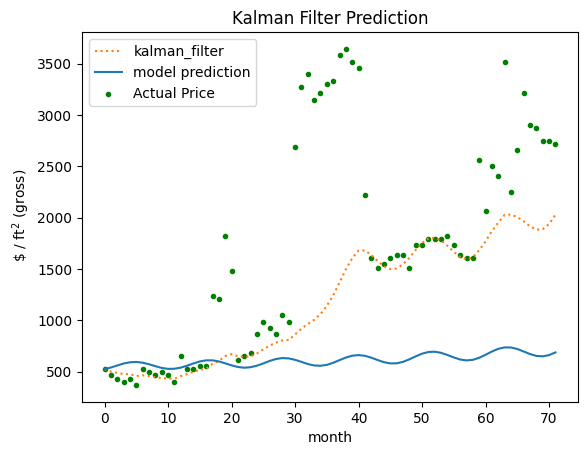

In [50]:
# Plot the results
tf = len(tls)
kalman_prices = kalman_filter(home1, tf=tf)
model_predictions = model_forecast(model, home1, tf, params)
plt.plot(tls, kalman_prices, label="kalman_filter", color="C1", ls=":")
plt.plot(tls, model_predictions, label="model prediction")
plt.scatter(tls, home1[:tf], label="Actual Price", color="g", marker='.')
plt.legend()
plt.title("Kalman Filter Prediction")
plt.xlabel("month")
plt.ylabel(r" \$ / ft$^2$ (gross)")
plt.show()

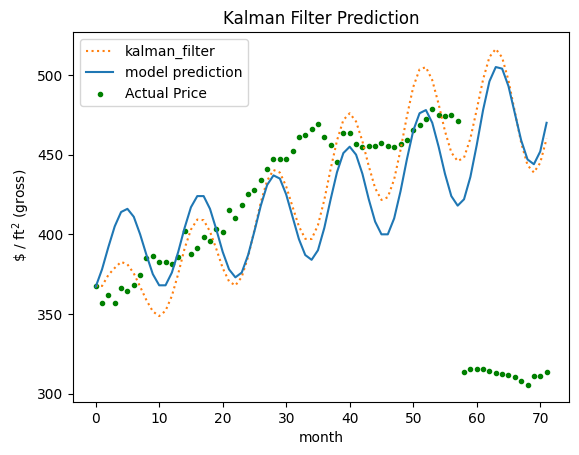

In [51]:
# Plot the results
tf = len(tls)
kalman_prices = kalman_filter(home2, tf=tf)
model_predictions = model_forecast(model, home2, tf, params)
plt.plot(tls, kalman_prices, label="kalman_filter", color="C1", ls=":")
plt.plot(tls, model_predictions, label="model prediction")
plt.scatter(tls, home2[:tf], label="Actual Price", color="g", marker='.')
plt.legend()
plt.title("Kalman Filter Prediction")
plt.xlabel("month")
plt.ylabel(r" \$ / ft$^2$ (gross)")
plt.show()

The two graphs above show the results of the Kalman filter process used on two specific homes whose pricing data was taken from Zillow. In the first home, the data deviates quite drastically from our model. The Kalman filter responds pretty well by averaging the model and data outcome. 

For the second graph, we can see that the data on the second home and the model are very intermingled until the last few observed months. The Kalman filter responds by mostly following the model, but adjusting for where the data points lie relative to the model prediction. 

Overall, the Kalman filter performs better than our model.